# Load Libraries

In [1]:
#Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns

from sklearn import linear_model, ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, f1_score, make_scorer

import pickle

# Initial Exploration

In [2]:
# Import Data
videogames = pd.read_csv('../data/vgsales.csv')

In [3]:
# Inspect Data
videogames.head()

Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37

In [4]:
# Inspect Data
videogames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [5]:
videogames.describe()

Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
std     4791.853933      5.828981      0.816683      0.505351      0.309291   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4151.250000   2003.000000      0.000000      0.000000      0.000000   
50%     8300.500000   2007.000000      0.080000      0.020000      0.000000   
75%    12449.750000   2010.000000      0.240000      0.110000      0.040000   
max    16600.000000   2020.000000     41.490000     29.020000     10.220000   

        Other_Sales  Global_Sales  
count  16598.000000  16598.000000  
mean       0.048063      0.537441  
std        0.188588      1.555028  
min        0.000000      0.010000  
25%        0.000000      0.060000  
50%        0.010000      0.170000  
75%        0.040000      0.470000  
max       10.570000     82.740000

## Missing Value Handling and Feature Engineering

The platforms variable is very granular and likely has some very small categories that are not useful.

Here I use a dictionary to create two new features from the platform variable: Platform Cat and Platform Type.

In [6]:
# Create Dict

platformcatsdict = {
    'DS' : ['Nintendo', 'Portable'],
    'PS2' : ['PlayStation', 'Console'],
    'PS3' : ['PlayStation', 'Console'],
    'Wii' : ['Nintendo', 'Console'],
    'X360' : ['Xbox', 'Console'],
    'PSP' : ['PlayStation', 'Portable'],
    'PS' : ['PlayStation', 'Console'],
    'PC' : ['PC', 'PC'],
    'XB' : ['Xbox', 'Console'],
    'GBA' : ['Nintendo', 'Portable'],
    'GC' : ['Nintendo', 'Console'],
    '3DS' : ['Nintendo', 'Portable'],
    'PSV' : ['PlayStation', 'Portable'],
    'PS4' : ['PlayStation', 'Console'],
    'N64' : ['Nintendo', 'Console'],
    'SNES' : ['Nintendo', 'Console'],
    'XOne' : ['Xbox', 'Console'],
    'SAT' : ['Other', 'Console'],
    'WiiU' : ['Nintendo', 'Console'],
    '2600' : ['Other', 'Console'],
    'GB' : ['Nintendo', 'Portable'],
    'NES' : ['Nintendo', 'Console'],
    'DC' : ['Other', 'Console'],
    'GEN' : ['Other', 'Console'],
    'NG' : ['Other', 'Console'],
    'WS' : ['Other', 'Portable'],
    'SCD' : ['Other', 'Console'],
    '3DO' : ['Other', 'Console'],
    'TG16' : ['Other', 'Console'],
    'GG' : ['Other', 'Console'],
    'PCFX' : ['Other', 'Console']
}

# Create new variables

videogames['platformcat'] = [platformcatsdict[x][0] for x in videogames['Platform']]

videogames['platformtype'] = [platformcatsdict[x][1] for x in videogames['Platform']]

In [7]:
# Change the data type of 'Year' column to int
videogames['Year'] = videogames['Year'].astype('int', errors = 'ignore')

In [8]:
# Remove games with erroneous release dates 
videogames.drop(videogames[videogames['Year'].isin([2017, 2020])].index, inplace = True)

Some of the video games that are missing 'Year' have their year in their 'Name'. We can fix these using a regular expression.

In [9]:
videogames[videogames['Year'].isna() == True]

Rank                         Name Platform  Year         Genre  \
179      180              Madden NFL 2004      PS2   NaN        Sports   
377      378             FIFA Soccer 2004      PS2   NaN        Sports   
431      432   LEGO Batman: The Videogame      Wii   NaN        Action   
470      471   wwe Smackdown vs. Raw 2006      PS2   NaN      Fighting   
607      608               Space Invaders     2600   NaN       Shooter   
...      ...                          ...      ...   ...           ...   
16307  16310                Freaky Flyers       GC   NaN        Racing   
16327  16330                    Inversion       PC   NaN       Shooter   
16366  16369  Hakuouki: Shinsengumi Kitan      PS3   NaN     Adventure   
16427  16430                 Virtua Quest       GC   NaN  Role-Playing   
16493  16496                   The Smurfs      3DS   NaN        Action   

                                    Publisher  NA_Sales  EU_Sales  JP_Sales  \
179                           Electronic Arts      4.26      0.26      0.01   
377                           Electronic Arts      0.59      2.36      0.04   
431    Warner Bros. Interactive Entertainment      1.86      1.02      0.00   
470                                       NaN      1.57      1.02      0.00   
607                                     Atari      2.36      0.14      0.00   
...                                       ...       ...       ...       ...   
16307                                 Unknown      0.01      0.00      0.00   
16327                      Namco Bandai Games      0.01      0.00      0.00   
16366                                 Unknown      0.01      0.00      0.00   
16427                                 Unknown      0.01      0.00      0.00   
16493                                 Unknown      0.00      0.01      0.00   

       Other_Sales  Global_Sales  platformcat platformtype  
179           0.71          5.23  PlayStation      Console  
377           0.51          3.49  PlayStation      Console  
431           0.29          3.17     Nintendo      Console  
470           0.41          3.00  PlayStation      Console  
607           0.03          2.53        Other      Console  
...            ...           ...          ...          ...  
16307         0.00          0.01     Nintendo      Console  
16327         0.00          0.01           PC           PC  
16366         0.00          0.01  PlayStation      Console  
16427         0.00          0.01     Nintendo      Console  
16493         0.00          0.01     Nintendo     Portable  

[271 rows x 13 columns]

In [10]:
# Define regular expression
# Selects a group of characters that begins with 19 or 20 and is followed by two other numbers
expression = '(19|20\d{2})'

# Use rank as a unique identifier and create a list of the records that will be changed so that I can check if the transformation works
checklist = list(videogames.loc[(videogames['Name'].str.contains(expression) & videogames['Year'].isna() == True), ['Name', 'Year', 'Rank']]['Rank'].values)

C:\Users\atyou\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [11]:
# Extract series to replace missing years
replacement_years = videogames[(videogames['Name'].str.contains(expression) & videogames['Year'].isna() == True)]['Name'].str.extract(expression).astype('int')
replacement_years = replacement_years - 1
replacement_years = replacement_years.values
replacement_years = replacement_years.reshape(-1,)

C:\Users\atyou\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [12]:
# Reassign missing years to the new replacement_years list
videogames.loc[(videogames['Name'].str.contains(expression) & videogames['Year'].isna() == True), 'Year'] = replacement_years

C:\Users\atyou\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [13]:
# Verify that the years were changed successfully
videogames[videogames['Rank'].isin(checklist)]

Rank                               Name Platform    Year     Genre  \
179      180                    Madden NFL 2004      PS2  2003.0    Sports   
377      378                   FIFA Soccer 2004      PS2  2003.0    Sports   
470      471         wwe Smackdown vs. Raw 2006      PS2  2005.0  Fighting   
1649    1651                NASCAR Thunder 2003      PS2  2002.0    Racing   
2586    2588     PES 2009: Pro Evolution Soccer      PSP  2008.0    Sports   
3501    3503                    Madden NFL 2002       XB  2001.0    Sports   
4797    4799                   NFL GameDay 2003      PS2  2002.0    Sports   
5162    5164                      NBA Live 2003       XB  2002.0    Sports   
5240    5242                 Tomb Raider (2013)       PC  2012.0    Action   
5669    5671             All-Star Baseball 2005      PS2  2004.0    Sports   
5901    5903                      NBA Live 2003       GC  2002.0    Sports   
8929    8931             All-Star Baseball 2005       XB  2004.0    Sports   
12922  12924                Tour de France 2011     X360  2010.0    Racing   
13870  13872                    Sega Rally 2006      PS2  2005.0    Racing   
15739  15742              Football Manager 2007     X360  2006.0    Sports   
15865  15868  PDC World Championship Darts 2008       DS  2007.0    Sports   
16057  16060  PDC World Championship Darts 2008      PSP  2007.0    Sports   

                          Publisher  NA_Sales  EU_Sales  JP_Sales  \
179                 Electronic Arts      4.26      0.26      0.01   
377                 Electronic Arts      0.59      2.36      0.04   
470                             NaN      1.57      1.02      0.00   
1649                        Unknown      0.60      0.46      0.00   
2586   Konami Digital Entertainment      0.04      0.33      0.26   
3501                        Unknown      0.53      0.02      0.00   
4797                        Unknown      0.20      0.15      0.00   
5162                Electronic Arts      0.31      0.04      0.00   
5240                    Square Enix      0.06      0.25      0.00   
5669                        Unknown      0.16      0.12      0.00   
5901                Electronic Arts      0.23      0.06      0.00   
8929                        Unknown      0.11      0.03      0.00   
12922        Focus Home Interactive      0.00      0.05      0.00   
13870                       Unknown      0.00      0.00      0.04   
15739                          Sega      0.00      0.01      0.00   
15865                       Unknown      0.01      0.00      0.00   
16057            Oxygen Interactive      0.01      0.00      0.00   

       Other_Sales  Global_Sales  platformcat platformtype  
179           0.71          5.23  PlayStation      Console  
377           0.51          3.49  PlayStation      Console  
470           0.41          3.00  PlayStation      Console  
1649          0.16          1.22  PlayStation      Console  
2586          0.17          0.80  PlayStation     Portable  
3501          0.03          0.58         Xbox      Console  
4797          0.05          0.40  PlayStation      Console  
5162          0.01          0.36         Xbox      Console  
5240          0.05          0.36           PC           PC  
5669          0.04          0.32  PlayStation      Console  
5901          0.01          0.30     Nintendo      Console  
8929          0.01          0.15         Xbox      Console  
12922         0.01          0.05         Xbox      Console  
13870         0.00          0.04  PlayStation      Console  
15739         0.00          0.02         Xbox      Console  
15865         0.00          0.02     Nintendo     Portable  
16057         0.00          0.01  PlayStation     Portable

In [14]:
# Remove all other rows that have a missing year

videogames.drop(videogames[videogames['Year'].isna() == True].index, inplace = True)

The remaining missing values are in the 'Publisher' column. They all appear to be very small games, so lets set their publisher to 'Other'

In [15]:
videogames.loc[videogames['Publisher'].isna() == True, 'Publisher'] = 'Other'

The publisher variable has 500+ unique values. Let's create two new ways to look at publisher. One will be a column that is a numerical count of the number of titles released by a publisher. The other will be a re-leveling of the Publisher categories to only include the top 11 publishers, as well as an 'Other' category.

In [16]:
# create new column that is the count of titles released by that publisher

publisher_title_count = videogames.groupby('Publisher').count().to_dict()
videogames['publisher_title_count'] = [publisher_title_count['Rank'][x] for x in videogames['Publisher']]

In [17]:
# create a new column that is the publisher name for any publishers with over X amount of titles released, 
# and 'Other' for anything else
# I'll use the 50th percentile as X for now (376)

for publisher in videogames['Publisher'].unique():
    if list(videogames.loc[videogames['Publisher'] == publisher, 'publisher_title_count'])[0] >= 376:
        videogames.loc[videogames['Publisher'] == publisher, 'Publisher_2'] = publisher
    else:
        videogames.loc[videogames['Publisher'] == publisher, 'Publisher_2'] = 'Other'

As of now we only have access to a few categorical variables and the 'Release Year' variable. Since this dataset has a time indicator (the 'Year' column), we can use that to create a new numerical feature. This feature will take a given observation and calculate the average sales for the publisher of that observation in all prior years.

In [18]:
# create new feature

videogames['pub_avg_prior_sales'] = 1.0
videogames.reset_index(drop = True, inplace = True)

for i in range(len(videogames['pub_avg_prior_sales'])):
    
    year = videogames['Year'][i]
    publisher = videogames['Publisher'][i]
    
    if np.isnan(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean()) == True:
        
        # execute this if the publisher does not have any prior titles
        videogames['pub_avg_prior_sales'][i] = 0.0
      
    else:
        
        # if the publisher does have prior titles, calculate their average sales
        videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A v

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publ

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-18-cb12dc250a1f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

## Exploratory Data Analysis

Before beginning EDA let's convert each of the sales variables to thousands instead of millions, and also create a log transformation of the global_sales variable.

In [19]:
videogames['NA_Sales'] = videogames['NA_Sales'] * 1000
videogames['EU_Sales'] = videogames['EU_Sales'] * 1000
videogames['JP_Sales'] = videogames['JP_Sales'] * 1000
videogames['Other_Sales'] = videogames['Other_Sales'] * 1000
videogames['Global_Sales'] = videogames['Global_Sales'] * 1000
videogames['pub_avg_prior_sales'] = videogames['pub_avg_prior_sales'] * 1000
videogames['log_Global_Sales'] = np.log10(videogames['Global_Sales'] * 1000)

Let's look at the distribution of the target variable.

(0.0, 2000.0)

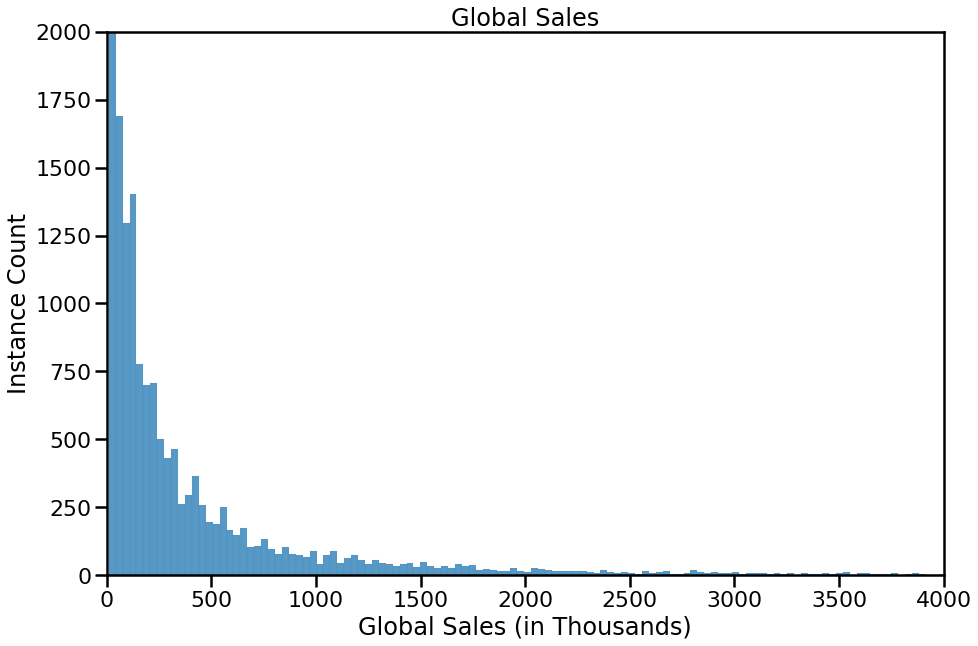

In [20]:
plt.figure(figsize = [15,10])
sns.set_context('poster')

ax = sns.histplot(videogames['Global_Sales'])
ax.set_title('Global Sales')
ax.set_xlabel('Global Sales (in Thousands)')
ax.set_ylabel('Instance Count')
ax.set_xlim([0,4000])
ax.set_ylim([0,2000])

Global Sales is extremely right skewed. Let's look at the log transformation, which we will likely use if we run any regression models.

Text(0, 0.5, 'Instance Count')

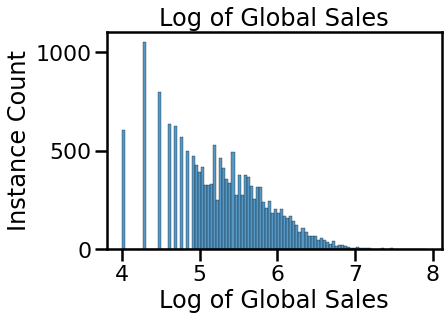

In [21]:
sns.histplot(videogames['log_Global_Sales'],bins = 100)
plt.title('Log of Global Sales')
plt.xlabel('Log of Global Sales')
plt.ylabel('Instance Count')

Let's look at correlations.

A lot of these appear to be highly correlated simply because they are dependent on each other.

The things to note are:
- Year does not appear to have a linear relationship with Global Sales. A decision tree/random forest model may be a good choice.
- Almost all of our explanatory variables are categorical, not numerical

In [22]:
videogames.corr()

Rank      Year  NA_Sales  EU_Sales  JP_Sales  \
Rank                   1.000000  0.178666 -0.400554 -0.379297 -0.268937   
Year                   0.178666  1.000000 -0.091513  0.005984 -0.169183   
NA_Sales              -0.400554 -0.091513  1.000000  0.768119  0.450804   
EU_Sales              -0.379297  0.005984  0.768119  1.000000  0.436052   
JP_Sales              -0.268937 -0.169183  0.450804  0.436052  1.000000   
Other_Sales           -0.333030  0.040916  0.634838  0.726202  0.290377   
Global_Sales          -0.427193 -0.074793  0.941160  0.902954  0.612424   
publisher_title_count -0.314956  0.013729  0.117791  0.122648  0.027259   
pub_avg_prior_sales   -0.376240 -0.217531  0.280321  0.222508  0.365289   
log_Global_Sales      -0.983440 -0.179553  0.499376  0.477925  0.339117   

                       Other_Sales  Global_Sales  publisher_title_count  \
Rank                     -0.333030     -0.427193              -0.314956   
Year                      0.040916     -0.074793               0.013729   
NA_Sales                  0.634838      0.941160               0.117791   
EU_Sales                  0.726202      0.902954               0.122648   
JP_Sales                  0.290377      0.612424               0.027259   
Other_Sales               1.000000      0.748239               0.114342   
Global_Sales              0.748239      1.000000               0.120929   
publisher_title_count     0.114342      0.120929               1.000000   
pub_avg_prior_sales       0.144591      0.309614               0.292640   
log_Global_Sales          0.414669      0.535021               0.309444   

                       pub_avg_prior_sales  log_Global_Sales  
Rank                             -0.376240         -0.983440  
Year                             -0.217531         -0.179553  
NA_Sales                          0.280321          0.499376  
EU_Sales                          0.222508          0.477925  
JP_Sales                          0.365289          0.339117  
Other_Sales                       0.144591          0.414669  
Global_Sales                      0.309614          0.535021  
publisher_title_count             0.292640          0.309444  
pub_avg_prior_sales               1.000000          0.397669  
log_Global_Sales                  0.397669          1.000000

Relationship between publisher_title_count and log_Global_Sales.

This variable is not of much use.

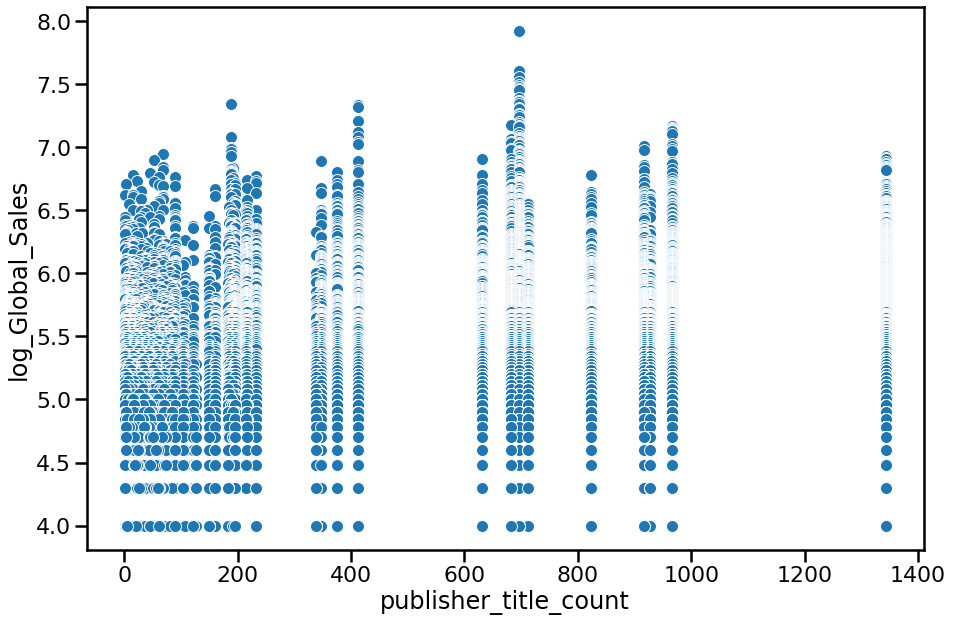

In [23]:
plt.figure(figsize = [15,10])
g = sns.scatterplot(x = 'publisher_title_count', y = 'log_Global_Sales', data = videogames)
plt.show()

Relationship between pub_avg_prior_sales and Global_Sales. There is a clear positive relationship here.

(0.0, 40000.0)

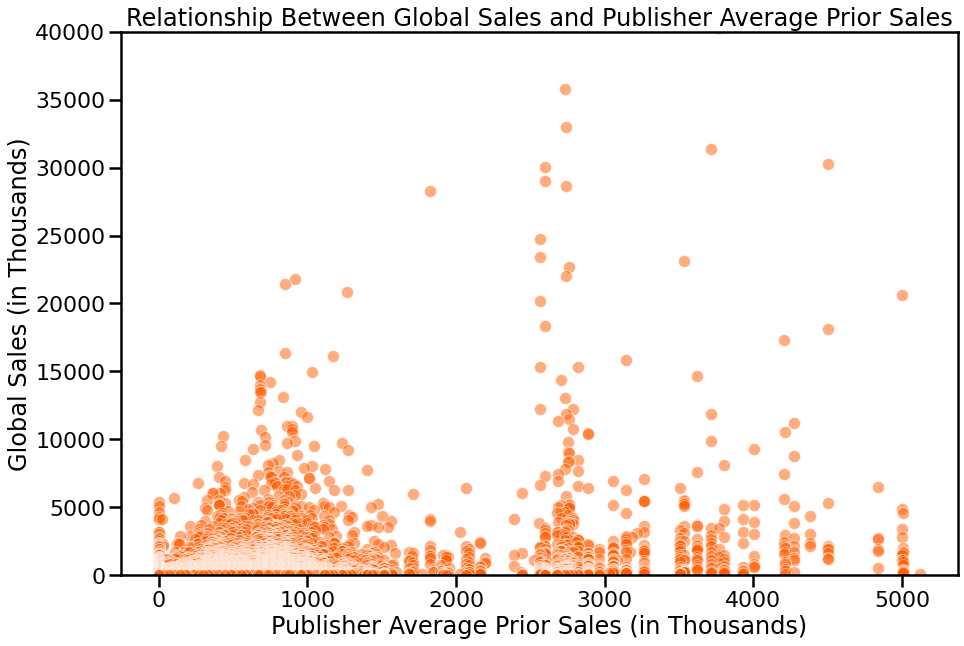

In [24]:
plt.figure(figsize = [15,10])
sns.set_context('poster')
ax = sns.scatterplot(x = 'pub_avg_prior_sales', y = 'Global_Sales', data = videogames, alpha = 0.5, color = '#ff5d00ff')
ax.set_xlabel('Publisher Average Prior Sales (in Thousands)')
ax.set_ylabel('Global Sales (in Thousands)')
ax.set_title('Relationship Between Global Sales and Publisher Average Prior Sales')
ax.set_ylim((0, 40000))

Now let's explore the categorical variables. First we'll define a function to make it easier.

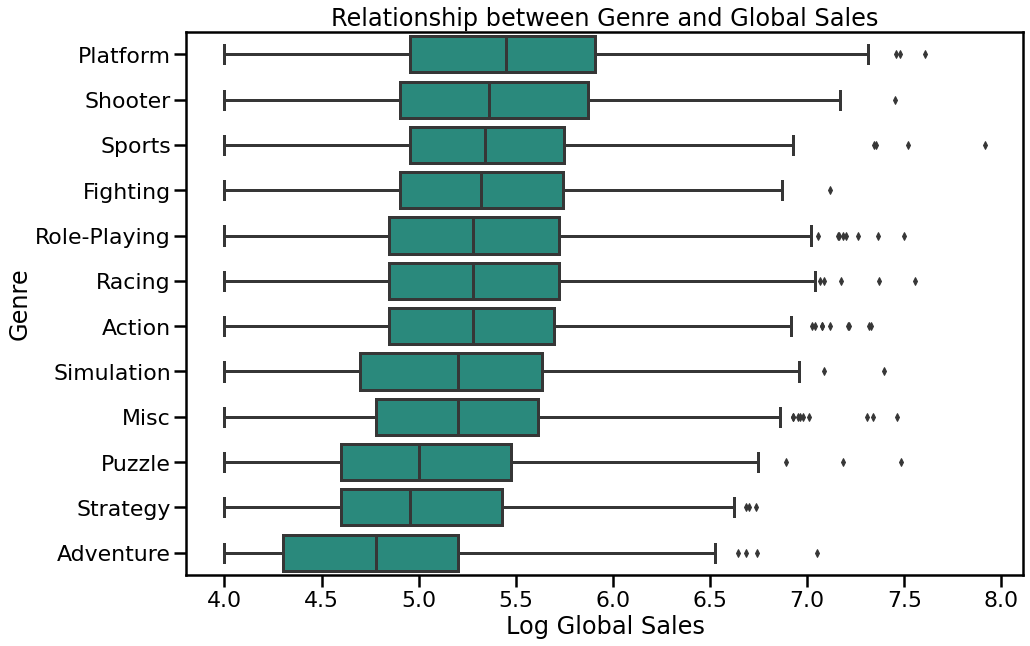

In [25]:

def ordered_boxplot(dataframe, y, grouping, color = None):
    """Create boxplot of categorical variable on x-axis and log_Global_Sales on y-axis.
    Sort boxplot in decreasing order of median log_Global_Sales by category."""
    
    my_order = videogames.groupby(grouping)[y].median().sort_values(ascending = False).index

    plt.figure(figsize = [15,10])

    return sns.boxplot(x = y, y = grouping, orient = 'h', data = dataframe, order = my_order, color = color)


# Genre
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'Genre', '#1a9988ff')
ax.set_title('Relationship between Genre and Global Sales')
ax.set_xlabel('Log Global Sales')
ax.set_ylabel('Genre')
plt.show()

# Platformers and Shooters appear to have very slightly higher medians but much higher 3rd quantiles
# Puzzle, adventure and strategy are significantly lower than the rest of the group

Platformers and shooters appear to have slightly higher medians. Puzzle, adventure and strategy seem to have significantly lower medians.

Now let's look at publisher.

Text(0.5, 0, 'Log Global Sales')

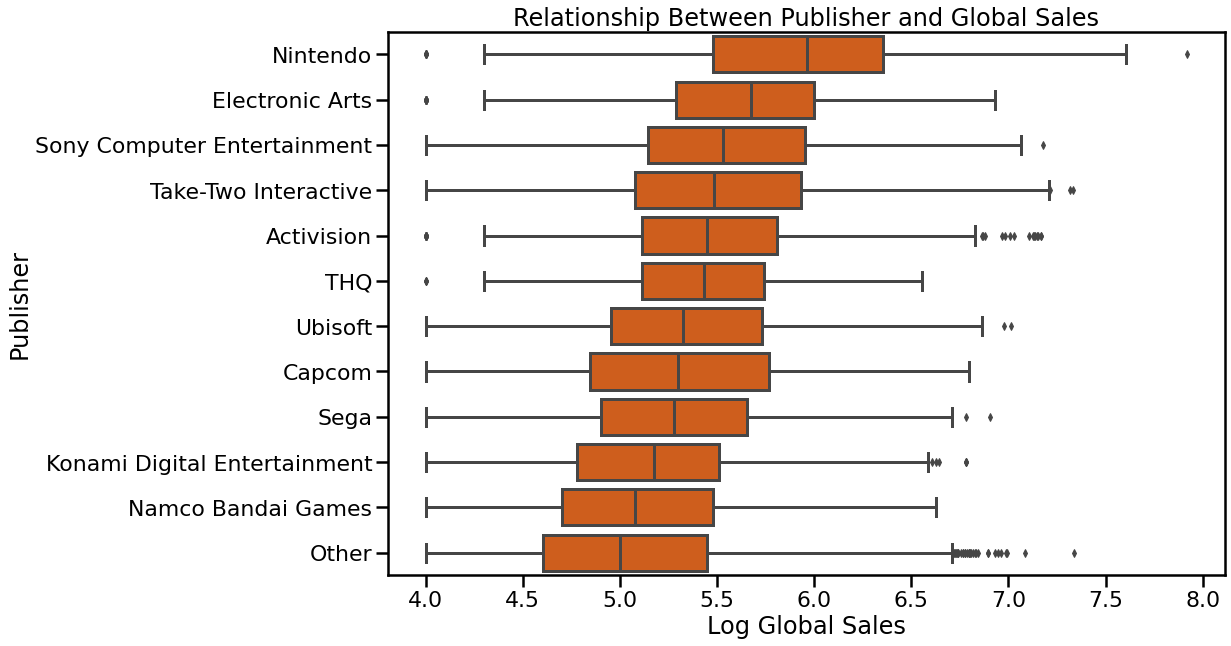

In [26]:
#Publisher_2
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'Publisher_2','#eb5600ff')
ax.set_title('Relationship Between Publisher and Global Sales')
ax.set_ylabel('Publisher')
ax.set_xlabel('Log Global Sales')
# other appears to lag significantly behind the top 12
# Nintendo seems to be in a league of it's own

Nintendo appears to be much higher than the other developers. The 'Other' category appears to be significantly lower than the top 11 publishers.

Now let's look at platform.

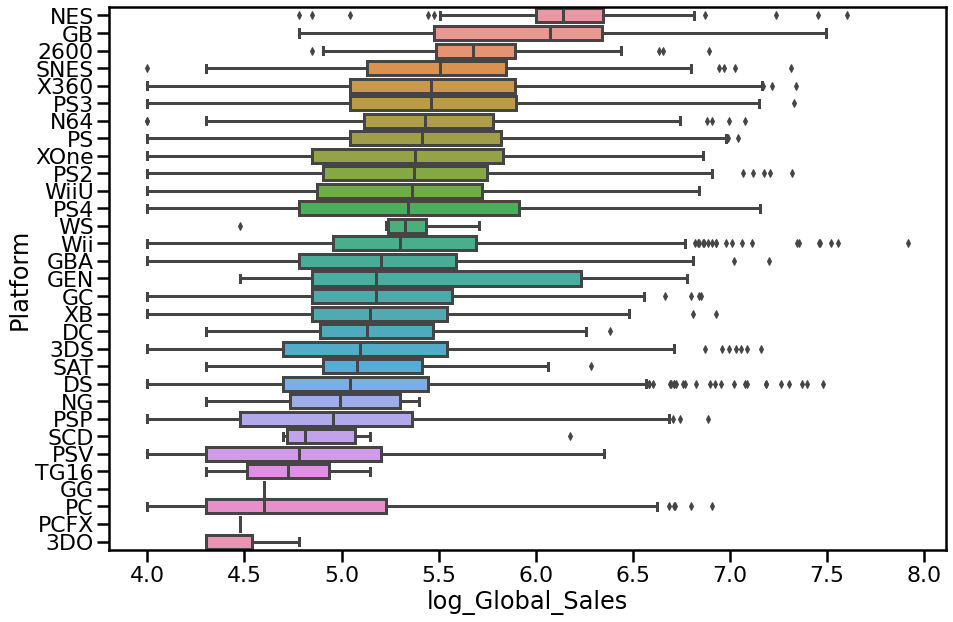

In [27]:
#Platform
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'Platform')

Text(0, 0.5, 'Platform Category')

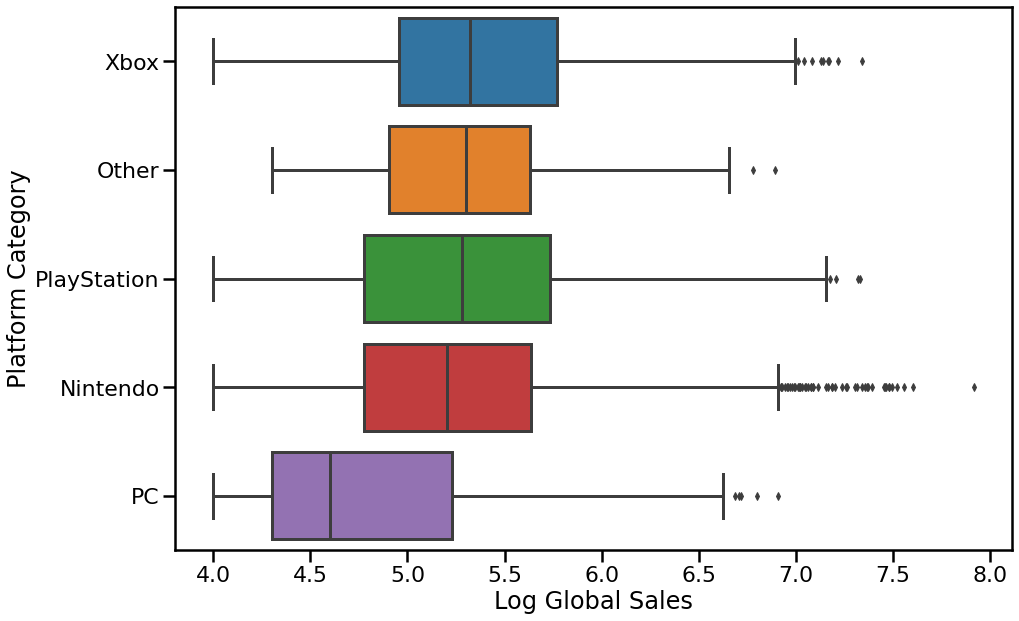

In [28]:
#Platformcat
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'platformcat')
ax.set_xlabel('Log Global Sales')
ax.set_ylabel('Platform Category')

Text(0, 0.5, 'Platform Type')

<Figure size 1080x720 with 0 Axes>

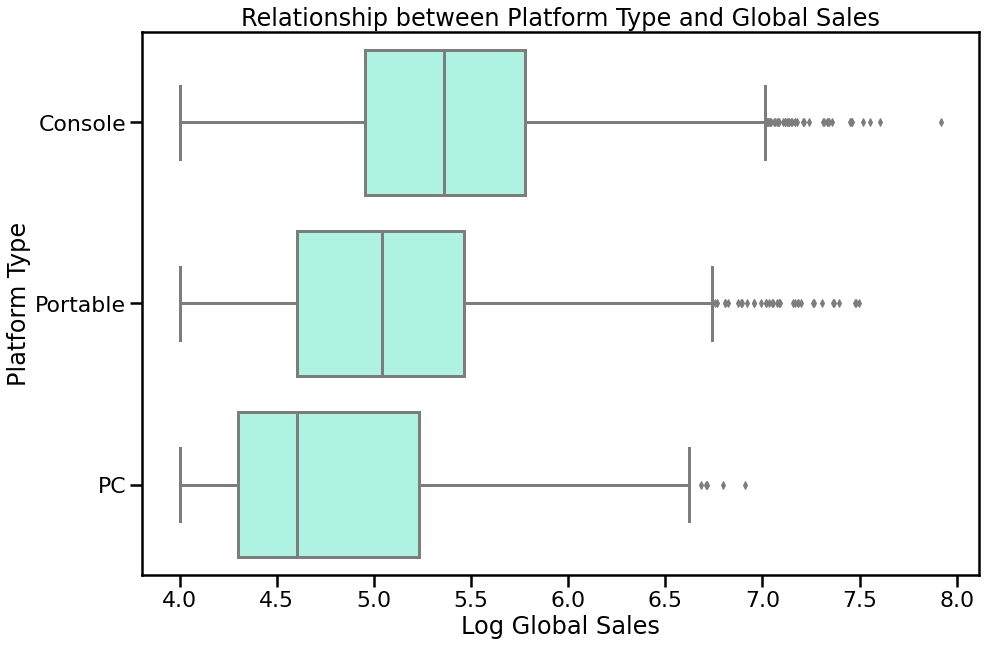

In [29]:
#Platformtype
plt.figure(figsize = (15,10))
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'platformtype', '#a2ffe8ff')
ax.set_title('Relationship between Platform Type and Global Sales')
ax.set_xlabel('Log Global Sales')
ax.set_ylabel('Platform Type')

Platform Type appears to be the platform variable that has the most clear relationship with Global Sales.

Based on the exploration above, I am not confident that I will be able to put together an accurate model for
predicting the continous log_Global_Sales variable. I may have to change the aim of this project to a 
classification task (i.e. try to predict whether a title will have over 1 million in sales)

# Preprocessing

Binarize categorical variables.

In [30]:
encoder = OneHotEncoder(categories = 'auto', drop = None, sparse = False, )
videogames_categorical = videogames[['Genre', 'platformtype', 'Publisher_2']]
videogames_binarized = pd.DataFrame(data = encoder.fit_transform(videogames_categorical), columns = encoder.get_feature_names())
videogames_binarized.reset_index(drop = True, inplace = True)
videogames_binarized.head()

x0_Action  x0_Adventure  x0_Fighting  x0_Misc  x0_Platform  x0_Puzzle  \
0        0.0           0.0          0.0      0.0          0.0        0.0   
1        0.0           0.0          0.0      0.0          1.0        0.0   
2        0.0           0.0          0.0      0.0          0.0        0.0   
3        0.0           0.0          0.0      0.0          0.0        0.0   
4        0.0           0.0          0.0      0.0          0.0        0.0   

   x0_Racing  x0_Role-Playing  x0_Shooter  x0_Simulation  ...  \
0        0.0              0.0         0.0            0.0  ...   
1        0.0              0.0         0.0            0.0  ...   
2        1.0              0.0         0.0            0.0  ...   
3        0.0              0.0         0.0            0.0  ...   
4        0.0              1.0         0.0            0.0  ...   

   x2_Electronic Arts  x2_Konami Digital Entertainment  x2_Namco Bandai Games  \
0                 0.0                              0.0                    0.0   
1                 0.0                              0.0                    0.0   
2                 0.0                              0.0                    0.0   
3                 0.0                              0.0                    0.0   
4                 0.0                              0.0                    0.0   

   x2_Nintendo  x2_Other  x2_Sega  x2_Sony Computer Entertainment  x2_THQ  \
0          1.0       0.0      0.0                             0.0     0.0   
1          1.0       0.0      0.0                             0.0     0.0   
2          1.0       0.0      0.0                             0.0     0.0   
3          1.0       0.0      0.0                             0.0     0.0   
4          1.0       0.0      0.0                             0.0     0.0   

   x2_Take-Two Interactive  x2_Ubisoft  
0                      0.0         0.0  
1                      0.0         0.0  
2                      0.0         0.0  
3                      0.0         0.0  
4                      0.0         0.0  

[5 rows x 27 columns]

Create train test split for regression models.

In [31]:
# Create predictor variables
X = pd.concat([videogames.loc[:,['Year','pub_avg_prior_sales']], videogames_binarized], axis = 1)

# Create target variable
y = videogames[['log_Global_Sales']]

# Create train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, train_size = .75, random_state = 123)
X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((12255, 29), (4085, 29), (12255, 1), (4085, 1))

## Linear Regression Testing

Basic linear regression.

In [32]:
# run model, evaluate R_squared, and look at coefficients
linear_model_1 = linear_model.LinearRegression()
linear_model_1.fit(X_train_reg, y_train_reg)
y_pred = linear_model_1.predict(X_train_reg)
linear_model_1.score(X_train_reg, y_train_reg), mean_absolute_error(y_train_reg, y_pred), linear_model_1.coef_

# We have a very low R_squared value of 0.2948, and it doesn't appear that the coefficients are even helpful

(0.29481847905573,
 0.42656367245306975,
 array([[-0.00476957,  0.00039182,  0.04986162, -0.23594805,  0.08214243,
         -0.00727487,  0.08261675, -0.08821616, -0.00983428,  0.12481478,
          0.0916178 ,  0.03854636, -0.02110076, -0.10722562,  0.22755806,
         -0.24743538,  0.01987731,  0.09373021, -0.1031493 ,  0.25065864,
         -0.05443567, -0.12291061, -0.32210881, -0.13853261,  0.02669497,
          0.05695274,  0.12335177,  0.05599765,  0.133751  ]]))

This model performs extremely poorly, with an R_squared value of 0.2948.

In [33]:
y_train_reg = np.ravel(y_train_reg)
y_test_reg = np.ravel(y_test_reg)

X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((12255, 29), (4085, 29), (12255,), (4085,))

In [34]:
# run this to reload the two models, the dataframe and the binarized categorical variables
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_1.pkl'

with open(filename, 'rb') as file:
    forest_classifier_1 = pickle.load(file)
    
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_model_1.pkl'

with open(filename, 'rb') as file:
    forest_model_1 = pickle.load(file)

filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_clean.pkl'

with open(filename, 'rb') as file:
    videogames = pickle.load(file)
    
filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_binarized.pkl'

with open(filename, 'rb') as file:
    videogames_binarized = pickle.load(file)

## Random Forest Regressor Testing

Now let's run a random forest regressor to see if we can get better results.

In [35]:
# Now let's run a random forest regressor to see if we can get a better result

# create model
forest_model_1 = ensemble.RandomForestRegressor(
    n_estimators = 100,
    criterion = 'mae',
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 2,
    random_state = 123,
    n_jobs = -1)

#fit model
forest_model_1.fit(X_train_reg, y_train_reg)

RandomForestRegressor(criterion='mae', min_samples_leaf=2, n_jobs=-1,
                      random_state=123)

In [36]:
# Evaluate Model
y_pred = forest_model_1.predict(X_train_reg)
forest_model_1.score(X_train_reg, y_train_reg), mean_absolute_error(y_train_reg, y_pred)

(0.631090407416333, 0.2893387703836012)

In [37]:
# Feature Importance
list(zip(X_train_reg.columns, forest_model_1.feature_importances_))

[('Year', 0.18212223724506385),
 ('pub_avg_prior_sales', 0.45952428709526943),
 ('x0_Action', 0.03010350815693186),
 ('x0_Adventure', 0.022292444228731716),
 ('x0_Fighting', 0.013776387402184263),
 ('x0_Misc', 0.022492591116773326),
 ('x0_Platform', 0.016098076347954324),
 ('x0_Puzzle', 0.010590580590841043),
 ('x0_Racing', 0.01883650320010664),
 ('x0_Role-Playing', 0.02168698273051845),
 ('x0_Shooter', 0.021570715553456014),
 ('x0_Simulation', 0.014433650913918626),
 ('x0_Sports', 0.02294775492040961),
 ('x0_Strategy', 0.012247448872583782),
 ('x1_Console', 0.03536453499163836),
 ('x1_PC', 0.01789705221486076),
 ('x1_Portable', 0.011403769330387356),
 ('x2_Activision', 0.005716912326362067),
 ('x2_Capcom', 0.005226472887071705),
 ('x2_Electronic Arts', 0.008157829309147862),
 ('x2_Konami Digital Entertainment', 0.003920124372966678),
 ('x2_Namco Bandai Games', 0.004856018960001607),
 ('x2_Nintendo', 0.0016261202267648124),
 ('x2_Other', 0.014688519143244415),
 ('x2_Sega', 0.0065308265

In [38]:
# Evaluate predictions
test_y_pred = forest_model_1.predict(X_test_reg)
mean_absolute_error(y_test_reg, test_y_pred)

0.3933128421407074

The random forest regressor was a significant improvement on the linear regression, with an R_squared of 0.63. However, there was a significant gap in performance between the training and the test set (0.91 MAE on test compared to 0.67 MAE on training). This may be somewhat addressed through hyperparameter tuning. 

The most important features by far were 'pub_avg_prior_sales' and 'year'.

## Random Forest Classifier Testing

For the last baseline model, let's run a random forest classifier to see if we can predict whether a title will have sales above a certain level. For now we'll use 1,000,000.

In [39]:
y_1000 = np.ravel(np.array([int(x > 1000) for x in videogames['Global_Sales']]))
X_train_1000, X_test_1000, y_train_1000, y_test_1000 = train_test_split(X, y_1000, train_size = 0.75, random_state = 123)
X_train_1000.shape, X_test_1000.shape, y_train_1000.shape, y_test_1000.shape


((12255, 29), (4085, 29), (12255,), (4085,))

In [40]:
# create model object

forest_classifier_1 = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 2,
    random_state = 123,
    n_jobs = -1)

#fit model
forest_classifier_1.fit(X_train_1000, y_train_1000)

RandomForestClassifier(min_samples_leaf=2, n_jobs=-1, random_state=123)

In [41]:
# evaluate model
y_pred = forest_classifier_1.predict(X_train_1000)
forest_classifier_1.score(X_train_1000, y_train_1000)

0.9109751121991024

In [42]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_train_1000, y_pred).ravel()

print('True Negatives: ' + str(tn)), print('False Positives :' + str(fp)), print('False Negative :' + str(fn)), print('True Positives :' + str(tp))





True Negatives: 10608
False Positives :112
False Negative :979
True Positives :556


(None, None, None, None)

In [43]:
# classification report
classification_report(y_train_1000, y_pred, output_dict = True)

{'0': {'precision': 0.9155087598170364,
  'recall': 0.9895522388059701,
  'f1-score': 0.9510915856009324,
  'support': 10720},
 '1': {'precision': 0.8323353293413174,
  'recall': 0.36221498371335503,
  'f1-score': 0.5047662278710848,
  'support': 1535},
 'accuracy': 0.9109751121991024,
 'macro avg': {'precision': 0.8739220445791769,
  'recall': 0.6758836112596626,
  'f1-score': 0.7279289067360086,
  'support': 12255},
 'weighted avg': {'precision': 0.9050908719524727,
  'recall': 0.9109751121991024,
  'f1-score': 0.8951871038289767,
  'support': 12255}}

In [44]:
# feature importances
list(zip(X_train_1000.columns, forest_classifier_1.feature_importances_))

[('Year', 0.2481313498269596),
 ('pub_avg_prior_sales', 0.3889947351402344),
 ('x0_Action', 0.019296376317444217),
 ('x0_Adventure', 0.009183076177171661),
 ('x0_Fighting', 0.010688737577294122),
 ('x0_Misc', 0.012863630806060596),
 ('x0_Platform', 0.019787777249234105),
 ('x0_Puzzle', 0.006156421947508116),
 ('x0_Racing', 0.013185901449518343),
 ('x0_Role-Playing', 0.014567852199443565),
 ('x0_Shooter', 0.01724273941879064),
 ('x0_Simulation', 0.008462772805700892),
 ('x0_Sports', 0.015059517828684659),
 ('x0_Strategy', 0.008049248097076933),
 ('x1_Console', 0.023540012928579195),
 ('x1_PC', 0.007166613259771562),
 ('x1_Portable', 0.01422932012722558),
 ('x2_Activision', 0.009313159853889292),
 ('x2_Capcom', 0.005344283999461703),
 ('x2_Electronic Arts', 0.017711998594443334),
 ('x2_Konami Digital Entertainment', 0.004303160604314104),
 ('x2_Namco Bandai Games', 0.005572853208644375),
 ('x2_Nintendo', 0.05629244142031471),
 ('x2_Other', 0.0298875865464252),
 ('x2_Sega', 0.008749212379

In [45]:
# Save random forest regressor
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_model_1.pkl'

with open(filename, 'wb') as file:
    pickle.dump(forest_model_1, file)


# Save random forest classifier
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_1.pkl'

with open(filename, 'wb') as file:
    pickle.dump(forest_classifier_1, file)
    
# Save videogames dataframe
filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_clean.pkl'

with open(filename, 'wb') as file:
    pickle.dump(videogames, file)

# Save dummy variables
filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_binarized.pkl'

with open(filename, 'wb') as file:
    pickle.dump(videogames_binarized, file)

PRELIMINARY RESULTS

We ran a simple linear regression, a random forest regressor and a random forest classifier on the videogames dataset along with some features that I created. 

The simple linear regression was not accurate at all (R-squared ~ 0.3).

The random forest regressor was fairly accurate (R-squared ~ 0.63) but may be prone to overfitting.

The random forest classifier was accurate (Accuracy ~ 0.91) but did not do well at predicting the minority class, which is the important one. The next step is to see if we can improve this performance through hyper-parameter tuning, different classificaiton threshholds, or different class separations (i.e. predict greater than 500,000 instead of greater than 1,000,000)

In [46]:
# First let's try setting our classes at different levels
X = pd.concat([videogames.loc[:,['Year','pub_avg_prior_sales']], videogames_binarized], axis = 1)

def class_cutoff_test(target_column, X, cutoffs, model):
    """Evaluate a model at different class cutoffs"""
    
    # Instantiate random forest classifier
    forest_classifier = ensemble.RandomForestClassifier(
        n_estimators = 100,
        criterion = 'gini',
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 2,
        random_state = 123)
    
    for cutoff in cutoffs:
        
        # Create train test splits
        y = np.ravel(np.array([int(x > cutoff) for x in target_column])) 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
        
        # Fit model
        forest_classifier.fit(X_train, y_train)
        
        # Generate results
        y_pred = forest_classifier.predict(X_test)
        report = classification_report(y_test, y_pred,output_dict = True)
        
        # Output
        print('{} Cutoff'.format(cutoff))
        print(report['1'])
    

class_cutoff_test(videogames['Global_Sales'], X, [1000, 750, 500, 250], forest_classifier_1)

1000 Cutoff
{'precision': 0.5112359550561798, 'recall': 0.22413793103448276, 'f1-score': 0.3116438356164384, 'support': 406}
750 Cutoff
{'precision': 0.5412186379928315, 'recall': 0.2760511882998172, 'f1-score': 0.36561743341404357, 'support': 547}
500 Cutoff
{'precision': 0.6181818181818182, 'recall': 0.38783269961977185, 'f1-score': 0.4766355140186916, 'support': 789}
250 Cutoff
{'precision': 0.6680923866552609, 'recall': 0.5912187736563209, 'f1-score': 0.6273092369477912, 'support': 1321}


Performance sharply increases for the lower cutoffs, due to having higher support. The $250,000 cutoff is the best performing, but offers the least relevant information. Let's move forward and try parameter tuning on the 500,000 cutoff.

In [47]:
# create train/test split
y_500 = np.ravel(np.array([int(x > 500) for x in videogames['Global_Sales']]))
X_train_500, X_test_500, y_train_500, y_test_500 = train_test_split(X, y_500, test_size = 0.25, random_state = 123)

# define parameter grid
params = {'criterion': ['gini', 'entropy'],
         'max_depth': [None, 2, 5, 10],
         'min_samples_split': [2, 5, 10, 50, 75, 100],
         'min_samples_leaf': [1, 2, 10, 50],
         'class_weight': [None, 'balanced', 'balanced_subsample'],
         'n_jobs': [-1],
         'random_state': [123]}

# instantiate model
model = ensemble.RandomForestClassifier()

# create f1 scorer
f1_scorer = make_scorer(f1_score)

# instantiate grid object
forestgrid = GridSearchCV(model, params, scoring = f1_scorer, n_jobs = -1, cv = 5)


#fit the grid search
#forestgrid.fit(X_train_500, y_train_500)

In [48]:
# Load final random forest classifier instead of rerunning grid search every time
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_final.pkl'

with open(filename, 'rb') as file:
    forest_classifier_final = pickle.load(file)

In [49]:
#gridresults = pd.DataFrame(forestgrid.cv_results_)

In [50]:
#gridresults.sort_values('rank_test_score')

In [51]:
# parameters for best model
#forest_classifier_final = forestgrid.best_estimator_
forest_classifier_final.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [52]:
# evaluate on test set
y_test_pred = forest_classifier_final.predict(X_test_500)
classification_report(y_test_500, y_test_pred, output_dict = True)

{'0': {'precision': 0.8945131375579598,
  'recall': 0.7448519948519948,
  'f1-score': 0.8128511235955055,
  'support': 3108},
 '1': {'precision': 0.47027388109552437,
  'recall': 0.7205731832139202,
  'f1-score': 0.5691188358932902,
  'support': 977},
 'accuracy': 0.7390452876376989,
 'macro avg': {'precision': 0.6823935093267421,
  'recall': 0.7327125890329576,
  'f1-score': 0.6909849797443979,
  'support': 4085},
 'weighted avg': {'precision': 0.7930488160001142,
  'recall': 0.7390452876376989,
  'f1-score': 0.754558236181781,
  'support': 4085}}

In [53]:
# Save final random forest classifier
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_final.pkl'

with open(filename, 'wb') as file:
    pickle.dump(forest_classifier_final, file)

Hyperparameter tuning allowed us to increase the recall to 0.72.

For fun, let's evaluate an adaboost model, even though it's not likely to produce great results on this dataset

In [54]:
# The random forest classifier was a slight success
# For fun, let's try an adaboost model and see what results we get

# define parameter grid
params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# instantiate model
model = ensemble.AdaBoostClassifier()

# create f1 scorer
f1_scorer = make_scorer(f1_score)

# instantiate grid object
adagrid = GridSearchCV(model, params, scoring = f1_scorer, n_jobs = -1, cv = 5)


#fit the grid search
adagrid.fit(X_train_500, y_train_500)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9, 1]},
             scoring=make_scorer(f1_score))

In [55]:
gridresults = pd.DataFrame(adagrid.cv_results_)

In [56]:
gridresults.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9       0.499878      0.152432         0.035102        0.012798   
8       0.634304      0.008078         0.044281        0.004306   
7       0.632919      0.003487         0.047673        0.001323   
5       0.639351      0.004324         0.048072        0.001163   
6       0.641945      0.004869         0.050066        0.002034   
4       0.622747      0.011087         0.048271        0.001850   
3       0.618944      0.005448         0.049268        0.003919   
2       0.612562      0.006597         0.046077        0.001715   
1       0.609769      0.007426         0.044282        0.000488   
0       0.611564      0.004155         0.045280        0.001353   

  param_learning_rate                  params  split0_test_score  \
9                   1    {'learning_rate': 1}           0.358914   
8                 0.9  {'learning_rate': 0.9}           0.342581   
7                 0.8  {'learning_rate': 0.8}           0.332518   
5                 0.6  {'learning_rate': 0.6}           0.323383   
6                 0.7  {'learning_rate': 0.7}           0.321295   
4                 0.5  {'learning_rate': 0.5}           0.308861   
3                 0.4  {'learning_rate': 0.4}           0.275132   
2                 0.3  {'learning_rate': 0.3}           0.273572   
1                 0.2  {'learning_rate': 0.2}           0.188953   
0                 0.1  {'learning_rate': 0.1}           0.188953   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
9           0.365541           0.360536           0.391048           0.368978   
8           0.348139           0.341646           0.383790           0.339394   
7           0.345588           0.353511           0.382878           0.326781   
5           0.346341           0.339670           0.384168           0.330498   
6           0.349206           0.336709           0.375000           0.338535   
4           0.320102           0.326003           0.365617           0.317897   
3           0.312258           0.319683           0.352217           0.303571   
2           0.231966           0.321149           0.348692           0.232493   
1           0.202312           0.192024           0.258427           0.194485   
0           0.131700           0.110236           0.170472           0.141321   

   mean_test_score  std_test_score  rank_test_score  
9         0.369003        0.011588                1  
8         0.351110        0.016592                2  
7         0.348255        0.019709                3  
5         0.344812        0.021174                4  
6         0.344149        0.017813                5  
4         0.327696        0.019745                6  
3         0.312572        0.024920                7  
2         0.281575        0.046915                8  
1         0.207240        0.025973                9  
0         0.148536        0.027990               10

As expected, the adaboost model was not effective.

Let's train an SVC and try to stack it on top of the random forest classifier to see if we can improve performance.

In [57]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate SVC, create train and test splits.
svc = LinearSVC()
X_svc = MinMaxScaler().fit_transform(X)
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_500, train_size = 0.75, random_state = 123)

# Define parameter grid
params = {'penalty': ['l1', 'l2'],
         'loss': ['hinge', 'squared_hinge'],
         'C': [0.1, 0.2, 0.5, 0.75, 1.0],
         'tol': [10**-4, 10**-3, 10**-2, 10**-1, 10**0],
         'class_weight': [None, 'balanced'],
         'random_state': [123]}

# Instantiate grid
svcgrid = GridSearchCV(svc, params, scoring = f1_scorer, n_jobs = -1, cv = 5)



In [58]:
# Fit model
#svcgrid.fit(X_train_svc, y_train_svc)

In [59]:
# Load final svc instead of rerunning grid search every time
filename = 'C:/Users/atyou/CapstoneTwo/Models/svc_classifier_final.pkl'

with open(filename, 'rb') as file:
    svc_classifier_final = pickle.load(file)

In [60]:
#gridresults = pd.DataFrame(svcgrid.cv_results_)
#gridresults.sort_values('rank_test_score')

In [61]:
#svc_classifier_final = svcgrid.best_estimator_
svc_classifier_final.get_params()

{'C': 0.75,
 'class_weight': 'balanced',
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 123,
 'tol': 0.1,
 'verbose': 0}

In [62]:
y_test_pred = svc_classifier_final.predict(X_test_svc)
classification_report(y_test_svc, y_test_pred, output_dict = True)

{'0': {'precision': 0.8753016894609815,
  'recall': 0.7001287001287001,
  'f1-score': 0.7779764032892383,
  'support': 3108},
 '1': {'precision': 0.4171357098186366,
  'recall': 0.6827021494370522,
  'f1-score': 0.5178571428571428,
  'support': 977},
 'accuracy': 0.6959608323133415,
 'macro avg': {'precision': 0.646218699639809,
  'recall': 0.6914154247828761,
  'f1-score': 0.6479167730731905,
  'support': 4085},
 'weighted avg': {'precision': 0.7657231920042934,
  'recall': 0.6959608323133415,
  'f1-score': 0.7157642815163724,
  'support': 4085}}

In [63]:
# Save final SVC
filename = 'C:/Users/atyou/CapstoneTwo/Models/svc_classifier_final.pkl'

with open(filename, 'wb') as file:
    pickle.dump(svc_classifier_final, file)

## Stacked Model Testing

As a last ditch effort let's test a stacked model combining the final random forest regressor as well as the final SVC.

In [64]:
# import pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# define estimators
estimators = [('rf', forest_classifier_final), ('svc', make_pipeline(MinMaxScaler(), svc_classifier_final))]

# instantiate stacking classifier
clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

In [65]:
clf.fit(X_train_500, y_train_500)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       min_samples_split=50,
                                                       n_jobs=-1,
                                                       random_state=123)),
                               ('svc',
                                Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('linearsvc',
                                                 LinearSVC(C=0.75,
                                                           class_weight='balanced',
                                                           random_state=123,
                                                           tol=0.1))]))],
                   final_estimator=LogisticRegression(

In [66]:
y_test_pred = clf.predict(X_test_500)
classification_report(y_test_500, y_test_pred, output_dict = True)

{'0': {'precision': 0.8294890510948905,
  'recall': 0.9140926640926641,
  'f1-score': 0.8697382519516301,
  'support': 3108},
 '1': {'precision': 0.5954545454545455,
  'recall': 0.4022517911975435,
  'f1-score': 0.4801466096518021,
  'support': 977},
 'accuracy': 0.7916768665850673,
 'macro avg': {'precision': 0.712471798274718,
  'recall': 0.6581722276451039,
  'f1-score': 0.6749424308017161,
  'support': 4085},
 'weighted avg': {'precision': 0.7735155597826219,
  'recall': 0.7916768665850673,
  'f1-score': 0.7765605201212918,
  'support': 4085}}

Interestingly the stacked model seems to have greatly improved precision, at the cost of greatly reduced recall. The random forest classifier still seems to be the best overall model.

# Final Model Metrics

In [67]:
# Parameters
forest_classifier_final.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [68]:
# Perforamnce on Training Set

y_train_pred = forest_classifier_final.predict(X_train_500)
classification_report(y_train_500, y_train_pred, output_dict = True)

{'0': {'precision': 0.9231854321620928,
  'recall': 0.7715143071482157,
  'f1-score': 0.8405627882538386,
  'support': 9331},
 '1': {'precision': 0.5216513349786852,
  'recall': 0.7951436388508892,
  'f1-score': 0.6299959355100935,
  'support': 2924},
 'accuracy': 0.7771521827825377,
 'macro avg': {'precision': 0.722418383570389,
  'recall': 0.7833289729995525,
  'f1-score': 0.735279361881966,
  'support': 12255},
 'weighted avg': {'precision': 0.8273808054657008,
  'recall': 0.7771521827825377,
  'f1-score': 0.7903222760202433,
  'support': 12255}}

In [69]:
# Performance on Test Set

y_test_pred = forest_classifier_final.predict(X_test_500)
classification_report(y_test_500, y_test_pred, output_dict = True)

{'0': {'precision': 0.8945131375579598,
  'recall': 0.7448519948519948,
  'f1-score': 0.8128511235955055,
  'support': 3108},
 '1': {'precision': 0.47027388109552437,
  'recall': 0.7205731832139202,
  'f1-score': 0.5691188358932902,
  'support': 977},
 'accuracy': 0.7390452876376989,
 'macro avg': {'precision': 0.6823935093267421,
  'recall': 0.7327125890329576,
  'f1-score': 0.6909849797443979,
  'support': 4085},
 'weighted avg': {'precision': 0.7930488160001142,
  'recall': 0.7390452876376989,
  'f1-score': 0.754558236181781,
  'support': 4085}}

In [70]:
# Feature Importance
feature_importances = pd.DataFrame({'Feature': X_train_500.columns, 'Importance': forest_classifier_final.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending = False)
feature_importances

Feature  Importance
1               pub_avg_prior_sales    0.396334
0                              Year    0.152117
23                         x2_Other    0.064568
14                       x1_Console    0.047339
22                      x2_Nintendo    0.041967
19               x2_Electronic Arts    0.030195
16                      x1_Portable    0.029581
3                      x0_Adventure    0.027962
5                           x0_Misc    0.015378
2                         x0_Action    0.015223
21            x2_Namco Bandai Games    0.013881
9                   x0_Role-Playing    0.013764
6                       x0_Platform    0.012557
15                            x1_PC    0.012487
10                       x0_Shooter    0.012257
12                        x0_Sports    0.012182
13                      x0_Strategy    0.011743
4                       x0_Fighting    0.010764
8                         x0_Racing    0.010392
11                    x0_Simulation    0.010328
28                       x2_Ubisoft    0.010012
7                         x0_Puzzle    0.007988
17                    x2_Activision    0.006947
20  x2_Konami Digital Entertainment    0.006885
25   x2_Sony Computer Entertainment    0.006739
24                          x2_Sega    0.006706
26                           x2_THQ    0.005279
18                        x2_Capcom    0.004440
27          x2_Take-Two Interactive    0.003985

[Text(0, 0, 'pub_avg_prior_sales'),
 Text(0, 1, 'Year'),
 Text(0, 2, 'x2_Other'),
 Text(0, 3, 'x1_Console'),
 Text(0, 4, 'x2_Nintendo'),
 Text(0, 5, 'x2_Electronic Arts'),
 Text(0, 6, 'x1_Portable'),
 Text(0, 7, 'x0_Adventure'),
 Text(0, 8, 'x0_Misc'),
 Text(0, 9, 'x0_Action'),
 Text(0, 10, 'x2_Namco Bandai Games'),
 Text(0, 11, 'x0_Role-Playing'),
 Text(0, 12, 'x0_Platform'),
 Text(0, 13, 'x1_PC'),
 Text(0, 14, 'x0_Shooter'),
 Text(0, 15, 'x0_Sports'),
 Text(0, 16, 'x0_Strategy'),
 Text(0, 17, 'x0_Fighting'),
 Text(0, 18, 'x0_Racing'),
 Text(0, 19, 'x0_Simulation'),
 Text(0, 20, 'x2_Ubisoft'),
 Text(0, 21, 'x0_Puzzle'),
 Text(0, 22, 'x2_Activision'),
 Text(0, 23, 'x2_Konami Digital Entertainment'),
 Text(0, 24, 'x2_Sony Computer Entertainment'),
 Text(0, 25, 'x2_Sega'),
 Text(0, 26, 'x2_THQ'),
 Text(0, 27, 'x2_Capcom'),
 Text(0, 28, 'x2_Take-Two Interactive')]

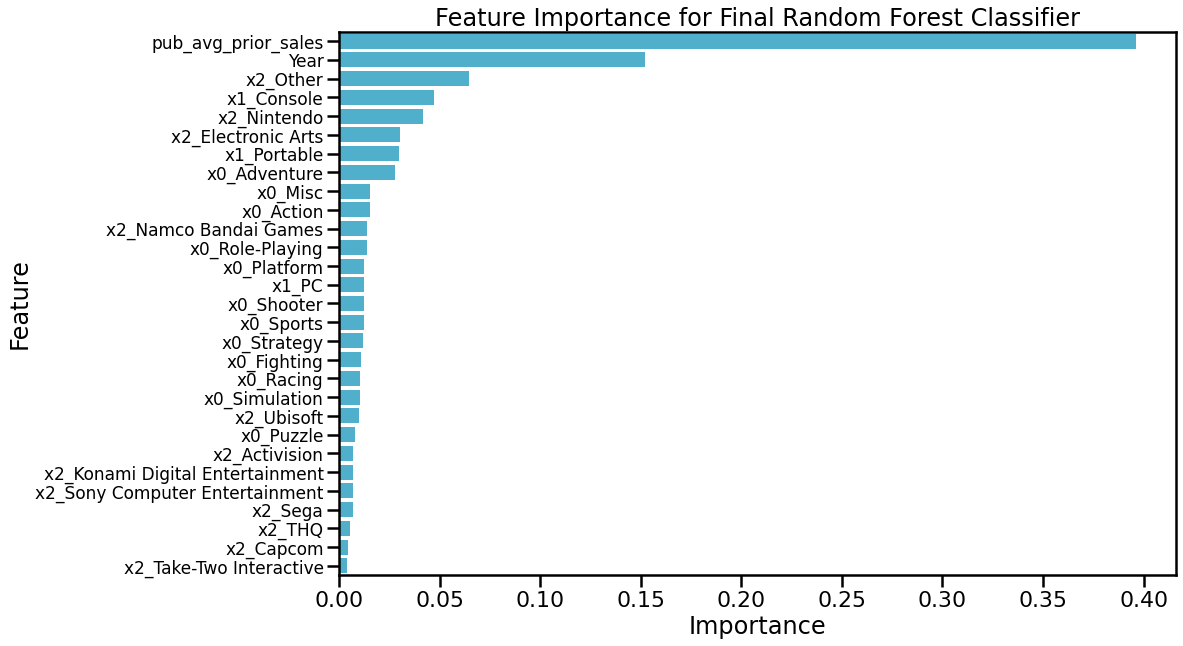

In [71]:
plt.figure(figsize = (15, 10))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = feature_importances, color = '#3bbbe1')
ax.set_title('Feature Importance for Final Random Forest Classifier')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 17)